In [1]:
from ray_diffusion.dataset.co3d_v2 import Co3dDataset
import torch
from pytorch3d.renderer import PerspectiveCameras, RayBundle
from pytorch3d.renderer.cameras import FoVPerspectiveCameras, look_at_view_transform
from pytorch3d.transforms import Rotate, Translate
from ray_diffusion.utils.rays import Rays, cameras_to_rays, rays_to_cameras, rays_to_cameras_homography
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import einops
from pytorch3d.vis.plotly_vis import plot_scene
cmap = plt.get_cmap("hsv")

batch_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_images = 100
translation_scale = 1.0
normalize_first_camera = True

train_dataset = Co3dDataset(
    category='chair',
    split="train",
    num_images=num_images,
    apply_augmentation=False,
    load_extra_cameras=False,
    transform=None,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

Loaded 1 instances of the chair category.
Low quality translation sequences, not used: []
Data size: 1
Data loading took 0.011473417282104492 seconds.


In [2]:
def intersect_skew_line_groups(p, r, mask):
    # p, r both of shape (B, N, n_intersected_lines, 3)
    # mask of shape (B, N, n_intersected_lines)
    p_intersect, r = intersect_skew_lines_high_dim(p, r, mask=mask)
    if p_intersect is None:
        return None, None, None, None
    _, p_line_intersect = point_line_distance(
        p, r, p_intersect[..., None, :].expand_as(p)
    )
    intersect_dist_squared = ((p_line_intersect - p_intersect[..., None, :]) ** 2).sum(
        dim=-1
    )
    return p_intersect, p_line_intersect, intersect_dist_squared, r

def intersect_skew_lines_high_dim(p, r, mask=None):
    # Implements https://en.wikipedia.org/wiki/Skew_lines In more than two dimensions
    dim = p.shape[-1]
    # make sure the heading vectors are l2-normed
    if mask is None:
        mask = torch.ones_like(p[..., 0])
    r = torch.nn.functional.normalize(r, dim=-1)

    eye = torch.eye(dim, device=p.device, dtype=p.dtype)[None, None]
    I_min_cov = (eye - (r[..., None] * r[..., None, :])) * mask[..., None, None]
    sum_proj = I_min_cov.matmul(p[..., None]).sum(dim=-3)

    # I_eps = torch.zeros_like(I_min_cov.sum(dim=-3)) + 1e-10
    # p_intersect = torch.pinverse(I_min_cov.sum(dim=-3) + I_eps).matmul(sum_proj)[..., 0]
    p_intersect = torch.linalg.lstsq(I_min_cov.sum(dim=-3), sum_proj).solution[..., 0]

    # I_min_cov.sum(dim=-3): torch.Size([1, 1, 3, 3])
    # sum_proj: torch.Size([1, 1, 3, 1])

    # p_intersect = np.linalg.lstsq(I_min_cov.sum(dim=-3).numpy(), sum_proj.numpy(), rcond=None)[0]

    if torch.any(torch.isnan(p_intersect)):
        print(p_intersect)
        return None, None
        ipdb.set_trace()
        assert False
    return p_intersect, r

def point_line_distance(p1, r1, p2):
    df = p2 - p1
    proj_vector = df - ((df * r1).sum(dim=-1, keepdim=True) * r1)
    line_pt_nearest = p2 - proj_vector
    d = (proj_vector).norm(dim=-1)
    return d, line_pt_nearest

def compute_optical_axis_intersection(cameras):
    centers = cameras.get_camera_center()
    principal_points = cameras.principal_point

    one_vec = torch.ones((len(cameras), 1), device=centers.device)
    optical_axis = torch.cat((principal_points, one_vec), -1)

    # optical_axis = torch.cat(
    #     (principal_points, cameras.focal_length[:, 0].unsqueeze(1)), -1
    # )

    pp = cameras.unproject_points(optical_axis, from_ndc=True, world_coordinates=True)
    pp2 = torch.diagonal(pp, dim1=0, dim2=1).T

    directions = pp2 - centers
    centers = centers.unsqueeze(0).unsqueeze(0)
    directions = directions.unsqueeze(0).unsqueeze(0)

    p_intersect, p_line_intersect, _, r = intersect_skew_line_groups(
        p=centers, r=directions, mask=None
    )

    if p_intersect is None:
        dist = None
    else:
        p_intersect = p_intersect.squeeze().unsqueeze(0)
        dist = (p_intersect - centers).norm(dim=-1)

    return p_intersect, dist, p_line_intersect, pp2, r

def normalize_cameras(cameras, scale=1.0):
    """
    Normalizes cameras such that the optical axes point to the origin, the rotation is
    identity, and the norm of the translation of the first camera is 1.

    Args:
        cameras (pytorch3d.renderer.cameras.CamerasBase).
        scale (float): Norm of the translation of the first camera.

    Returns:
        new_cameras (pytorch3d.renderer.cameras.CamerasBase): Normalized cameras.
        undo_transform (function): Function that undoes the normalization.
    """

    # Let distance from first camera to origin be unit
    new_cameras = cameras.clone()
    new_transform = (
        new_cameras.get_world_to_view_transform()
    )  # potential R is not valid matrix
    p_intersect, dist, p_line_intersect, pp, r = compute_optical_axis_intersection(
        cameras
    )

    if p_intersect is None:
        print("Warning: optical axes code has a nan. Returning identity cameras.")
        new_cameras.R[:] = torch.eye(3, device=cameras.R.device, dtype=cameras.R.dtype)
        new_cameras.T[:] = torch.tensor(
            [0, 0, 1], device=cameras.T.device, dtype=cameras.T.dtype
        )
        return new_cameras, lambda x: x

    d = dist.squeeze(dim=1).squeeze(dim=0)[0]
    # Degenerate case
    if d == 0:
        print(cameras.T)
        print(new_transform.get_matrix()[:, 3, :3])
        assert False
    assert d != 0

    # Can't figure out how to make scale part of the transform too without messing up R.
    # Ideally, we would just wrap it all in a single Pytorch3D transform so that it
    # would work with any structure (eg PointClouds, Meshes).
    tR = Rotate(new_cameras.R[0].unsqueeze(0)).inverse()
    tT = Translate(p_intersect)
    t = tR.compose(tT)

    new_transform = t.compose(new_transform)
    new_cameras.R = new_transform.get_matrix()[:, :3, :3]
    new_cameras.T = new_transform.get_matrix()[:, 3, :3] / d * scale

    def undo_transform(cameras):
        cameras_copy = cameras.clone()
        cameras_copy.T *= d / scale
        new_t = (
            t.inverse().compose(cameras_copy.get_world_to_view_transform()).get_matrix()
        )
        cameras_copy.R = new_t[:, :3, :3]
        cameras_copy.T = new_t[:, 3, :3]
        return cameras_copy

    return new_cameras, undo_transform

def first_camera_transform(cameras, rotation_only=True):
    new_cameras = cameras.clone()
    new_transform = new_cameras.get_world_to_view_transform()
    tR = Rotate(new_cameras.R[0].unsqueeze(0))
    if rotation_only:
        t = tR.inverse()
    else:
        tT = Translate(new_cameras.T[0].unsqueeze(0))
        t = tR.compose(tT).inverse()

    new_transform = t.compose(new_transform)
    new_cameras.R = new_transform.get_matrix()[:, :3, :3]
    new_cameras.T = new_transform.get_matrix()[:, 3, :3]

    return new_cameras

def normalize_cameras_batch(cam, scale=1.0, normalize_first_camera=False):

    if normalize_first_camera:
        # Normalize cameras such that first camera is identity and origin is at
        # first camera center.
        normalized_cameras = first_camera_transform(cam, rotation_only=False)
        undo_transform = None
    else:
        normalized_cameras, undo_transform = normalize_cameras(cam, scale=scale)

    return normalized_cameras, undo_transform

In [3]:
for i, batch in enumerate(train_dataloader):
    print(i)
    print(batch.keys())


    break

0
dict_keys(['model_id', 'category', 'n', 'ind', 'image', 'R', 'T', 'focal_length', 'principal_point', 'image_size', 'crop_parameters', 'filename'])


In [4]:
images = batch["image"].to(device).squeeze(0)
focal_lengths = batch["focal_length"].to(device).squeeze(0)
crop_params = batch["crop_parameters"].to(device).squeeze(0)
principal_points = batch["principal_point"].to(device).squeeze(0)
R = batch["R"].to(device).squeeze(0)
T = batch["T"].to(device).squeeze(0)
print(images.shape)
print(focal_lengths.shape)
print(crop_params.shape)
print(principal_points.shape)
print(R.shape)
print(T.shape)

num_train = 80
number_of_patch = 4
train_images = images[:num_train]
train_focal_lengths = focal_lengths[:num_train]
train_crop_params = crop_params[:num_train]
train_principal_points = principal_points[:num_train]
train_R = R[:num_train]
train_T = T[:num_train]

test_images = images[num_train:]
test_focal_lengths = focal_lengths[num_train:]
test_crop_params = crop_params[num_train:]
test_principal_points = principal_points[num_train:]
test_R = R[num_train:]
test_T = T[num_train:]

torch.Size([100, 3, 224, 224])
torch.Size([100, 2])
torch.Size([100, 4])
torch.Size([100, 2])
torch.Size([100, 3, 3])
torch.Size([100, 3])


In [5]:
def convert_RT_to_camera(R, T, focal_lengths, principal_points):
    cameras_og = PerspectiveCameras(
            focal_length=focal_lengths,
            principal_point=principal_points,
            R=R,
            T=T,
            device=device,
        )
    cameras, undo_transform = normalize_cameras_batch(
        cam=cameras_og,
        scale=1.0,
        normalize_first_camera=False,
    )
    return cameras, undo_transform

def convert_cameras_to_Plucker(cameras, crop_params):
    r = cameras_to_rays(
        cameras=cameras,
        num_patches_x=number_of_patch,
        num_patches_y=number_of_patch,
        crop_parameters=crop_params,
    )
    return r

def convert_RT_to_Plucker(R, T, focal_lengths, principal_points, crop_params):
    cameras, undo_transform = convert_RT_to_camera(R, T, focal_lengths, principal_points)
    r = convert_cameras_to_Plucker(cameras, crop_params)
    return r, undo_transform

def convert_Plucker_to_RT(r, crop_params):
    pred_cam = rays_to_cameras_homography(
        r,
        crop_params,
        num_patches_x=number_of_patch,
        num_patches_y=number_of_patch,
        # focal_length=focal_lengths[0],
    )
    return pred_cam



In [6]:
train_cameras, undo_transform = convert_RT_to_camera(train_R, train_T, train_focal_lengths, train_principal_points)
rays = convert_cameras_to_Plucker(train_cameras, train_crop_params)
print(rays.shape)


pred_cam = convert_Plucker_to_RT(rays, train_crop_params)
print(undo_transform(pred_cam).R[0])
print(undo_transform(train_cameras).R[0])

torch.Size([80, 16, 6])
tensor([[-0.6833,  0.5445,  0.4864],
        [-0.5052, -0.8336,  0.2234],
        [ 0.5271, -0.0930,  0.8447]], device='cuda:0')
tensor([[-0.6833,  0.5444,  0.4865],
        [-0.5052, -0.8336,  0.2232],
        [ 0.5271, -0.0933,  0.8447]], device='cuda:0')


In [22]:


def create_plotly_cameras_visualization(cameras_gt, cameras_pred, num):
    R, T = look_at_view_transform(2, 60, 180) # 2 camera angles, front and back
    # Any instance of CamerasBase works, here we use FoVPerspectiveCameras
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    num_frames = cameras_gt.R.shape[0]
    name = f"Vis {num} GT vs Pred Cameras"
    camera_scale = 0.05

    # Cameras_pred is already a 2D list of unbatched cameras
    # But cameras_gt is a 1D list of batched cameras
    scenes = {f"Vis {num} GT vs Pred Cameras": {}}
    for i in range(num_frames):
        scenes[name][f"Pred Camera {i}"] = PerspectiveCameras(
            R=cameras_pred[i].R, T=cameras_pred[i].T
        )
    for i in range(num_frames):
        scenes[name][f"GT Camera {i}"] = PerspectiveCameras(
            R=cameras_gt.R[i].unsqueeze(0), T=cameras_gt.T[i].unsqueeze(0)
        )

    fig = plot_scene(
        scenes,
        camera_scale=camera_scale,
        viewpoint_cameras=cameras
    )
    fig.update_scenes(aspectmode="data")
    fig.update_layout(height=800, width=800)

    for i in range(num_frames):
        fig.data[i].line.color = matplotlib.colors.to_hex(cmap(i / (num_frames)))
        fig.data[i].line.width = 4
        fig.data[i + num_frames].line.dash = "dash"
        fig.data[i + num_frames].line.color = matplotlib.colors.to_hex(
            cmap(i / (num_frames))
        )
        fig.data[i + num_frames].line.width = 4
    plt.close()
    return fig


def create_fig_moments(moments, directions):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4.5), dpi=100)

    vis = (
        torch.nn.functional.normalize(moments, dim=-1) + 1
    ) / 2
    axs[0].imshow(vis.reshape(number_of_patch, number_of_patch, 3).cpu())
    # close display
    # dont use imshow 

    axs[0].set_title("Moments")


    vis = (
        torch.nn.functional.normalize(directions, dim=-1) + 1
    ) / 2
    axs[1].imshow(vis.reshape(number_of_patch, number_of_patch, 3).cpu())
    axs[1].set_title("Directions")
    plt.close()
    return fig

Epoch 0, Loss: 9.081, Val Loss: 6.065
Epoch 1, Loss: 7.453, Val Loss: 6.304
Epoch 2, Loss: 7.255, Val Loss: 6.541
Epoch 3, Loss: 7.121, Val Loss: 6.709
Epoch 4, Loss: 7.031, Val Loss: 6.817


KeyboardInterrupt: 

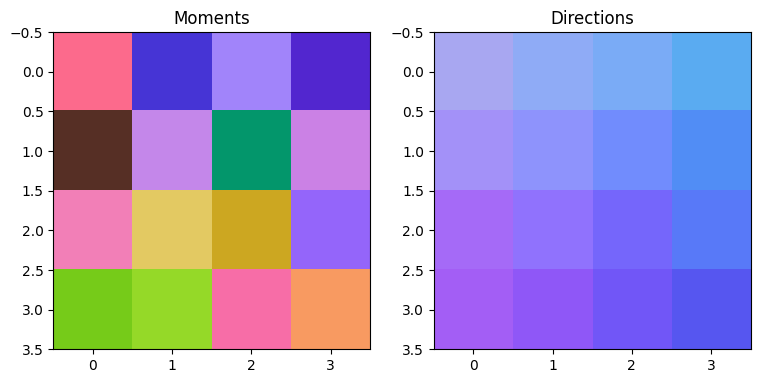

In [23]:
# define a simple CNN that takes 3,224,224 as input a resnet based
import pickle

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.fc2 = nn.Linear(512, 6 * number_of_patch * number_of_patch)
        self.resnet.fc = nn.Linear(512, 512)

    def forward(self, x):
        return self.fc2(self.resnet(x))
    
net = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# train only fc1 and fc2
for name, param in net.named_parameters():
    if "fc" in name or "fc2" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


cams_gt_seen, undos_seen = convert_RT_to_camera(train_R, train_T, train_focal_lengths, train_principal_points)
cams_gt_unseen, undos_unseen = convert_RT_to_camera(test_R, test_T, test_focal_lengths, test_principal_points)
fig_seen_l = []
fig_unseen_l = []
fig_seen_undo_l = []
fig_unseen_undo_l = []
loss_dict = {}
for epoch in range(1500):  # loop over the dataset multiple times
    running_loss = 0.0
    running_loss_val = 0.0
    seen_pred_list = []
    # iterate over batch size
    for i in range(num_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs = train_images[i].unsqueeze(0)
        labels_rays, _ = convert_RT_to_Plucker(train_R[i].unsqueeze(0), train_T[i].unsqueeze(0), train_focal_lengths[i].unsqueeze(0), train_principal_points[i].unsqueeze(0), train_crop_params[i].unsqueeze(0))
        # zero the parameter gradients
        optimizer.zero_grad()
        # labels = einops.rearrange(labels[0].rays, 'n (h w) -> n h w', h=number_of_patch, w=number_of_patch)
        # print(labels_rays.rays.shape)
    
        labels = einops.rearrange(labels_rays.rays, 'n hw d -> n (hw d)')
        # labels = labels_rays.rays.unsqueeze(0).view(1,-1)
        # print(labels.shape)
        # print(inputs.shape)
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        outputs = einops.rearrange(outputs, 'n (h w d) -> n d h w', h=number_of_patch, w=number_of_patch, d=6)
        
        loss.backward()
        optimizer.step()
        seen_pred_list.append(outputs)
        # print statistics
        running_loss += loss.item()

        if i == 0:
            fig_seen_gt = create_fig_moments(labels_rays.get_moments(), labels_rays.get_directions())
            fig_seen_gt.savefig(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/moments_dirs/train/fig_seen_gt_{epoch}.png")

    outputs_torch = torch.cat(seen_pred_list, dim=0).detach()
    pred_rays = Rays.from_spatial(outputs_torch)
    fig_seen = create_fig_moments(pred_rays[0].get_moments(), pred_rays[0].get_directions())
    fig_seen.savefig(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/moments_dirs/train/fig_seen_{epoch}.png")
    
    

    cams_pred_seen = convert_Plucker_to_RT(pred_rays, train_crop_params[i].unsqueeze(0))
    fig_seen_l.append(create_plotly_cameras_visualization(cams_gt_seen, cams_pred_seen, 20))
    cams_pred_seen = undos_seen(cams_pred_seen)
    fig_seen_undo_l.append(create_plotly_cameras_visualization(cams_gt_seen, cams_pred_seen, 20))
    fig_seen_l[epoch].write_image(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/scene/train/fig_seen_{epoch}.png")
    fig_seen_undo_l[epoch].write_image(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/scene/train/fig_seen_undo_{epoch}.png")

    # fig_seen = create_plotly_cameras_visualization(cams_gt_seen, cams_pred_seen, 40)
    # validation
    unseen_pred_list = []
    with torch.no_grad():
        for j in range(num_images-num_train):
            inputs = test_images[j].unsqueeze(0)
            labels_rays, _ = convert_RT_to_Plucker(test_R[j].unsqueeze(0), test_T[j].unsqueeze(0), test_focal_lengths[j].unsqueeze(0), test_principal_points[j].unsqueeze(0), test_crop_params[j].unsqueeze(0))
            labels = einops.rearrange(labels_rays.rays, 'n hw d -> n (hw d)')
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item()
            outputs = einops.rearrange(outputs, 'n (h w d) -> n d h w', h=number_of_patch, w=number_of_patch, d=6)
            unseen_pred_list.append(outputs)
            if j == 0:
                fig_unseen_gt = create_fig_moments(labels_rays.get_moments(), labels_rays.get_directions())
                fig_unseen_gt.savefig(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/moments_dirs/val/fig_unseen_gt_{epoch}.png")

    outputs_torch = torch.cat(unseen_pred_list, dim=0)
    pred_rays = Rays.from_spatial(outputs_torch)
    cams_pred_unseen = convert_Plucker_to_RT(pred_rays, test_crop_params[j].unsqueeze(0))
    fig_unseen_l.append(create_plotly_cameras_visualization(cams_gt_unseen, cams_pred_unseen, 20))
    cams_pred_unseen = undos_unseen(cams_pred_unseen)
    fig_unseen_undo_l.append(create_plotly_cameras_visualization(cams_gt_unseen, cams_pred_unseen, 20))
    fig_unseen = create_fig_moments(pred_rays[0].get_moments(), pred_rays[0].get_directions())
    fig_unseen.savefig(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/moments_dirs/val/fig_unseen_{epoch}.png")

    fig_unseen_l[epoch].write_image(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/scene/val/fig_unseen_{epoch}.png")
    fig_unseen_undo_l[epoch].write_image(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/scene/val/fig_unseen_undo_{epoch}.png")
    # fig_unseen = create_plotly_cameras_visualization(cams_gt_unseen, cams_pred_unseen, 20)
    # print only 2 decimal points
    epoch_loss = running_loss/num_train * 100
    epoch_val_loss = running_loss_val/(num_images-num_train) * 100
    print(f"Epoch {epoch}, Loss: {epoch_loss:.3f}, Val Loss: {epoch_val_loss:.3f}")
    loss_dict[epoch] = [epoch_loss, epoch_val_loss]
    # save loss_dict
    if epoch % 10 == 0:
        with open(f"/sensei-fs-3/users/okara/camera_as_rays/RayDiffusion/output_images/loss_dict.pkl", "wb") as f:
            pickle.dump(loss_dict, f)



In [42]:
fig_seen_l[0].show()
fig_seen_l[0].write_image("image_name.png")


In [43]:
fig_unseen_l[0].show()

In [20]:
cams_gt, undos = convert_RT_to_camera(test_R, test_T, test_focal_lengths, test_principal_points)
outputs_list = []
with torch.no_grad():
    for i in range(num_images-num_train):
        inputs = test_images[i].unsqueeze(0)
        outputs = net(inputs)
        outputs = outputs.view(1, 6, 4, 4)
        print(outputs.shape)
        outputs_list.append(outputs)
outputs_torch = torch.cat(outputs_list, dim=0)

pred_rays = Rays.from_spatial(outputs_torch)
pred_cam = convert_Plucker_to_RT(pred_rays, test_crop_params[i].unsqueeze(0))



In [25]:
def create_plotly_cameras_visualization(cameras_gt, cameras_pred, num):
    num_frames = cameras_gt.R.shape[0]
    name = f"Vis {num} GT vs Pred Cameras"
    camera_scale = 0.05

    # Cameras_pred is already a 2D list of unbatched cameras
    # But cameras_gt is a 1D list of batched cameras
    scenes = {f"Vis {num} GT vs Pred Cameras": {}}
    for i in range(num_frames):
        scenes[name][f"Pred Camera {i}"] = PerspectiveCameras(
            R=cameras_pred[i].R, T=cameras_pred[i].T
        )
    for i in range(num_frames):
        scenes[name][f"GT Camera {i}"] = PerspectiveCameras(
            R=cameras_gt.R[i].unsqueeze(0), T=cameras_gt.T[i].unsqueeze(0)
        )

    fig = plot_scene(
        scenes,
        camera_scale=camera_scale,
    )
    fig.update_scenes(aspectmode="data")
    fig.update_layout(height=800, width=800)

    for i in range(num_frames):
        fig.data[i].line.color = matplotlib.colors.to_hex(cmap(i / (num_frames)))
        fig.data[i].line.width = 4
        fig.data[i + num_frames].line.dash = "dash"
        fig.data[i + num_frames].line.color = matplotlib.colors.to_hex(
            cmap(i / (num_frames))
        )
        fig.data[i + num_frames].line.width = 4

    return fig

In [26]:
fig = create_plotly_cameras_visualization(cams_gt, pred_cam, 10)

In [44]:
labels = convert_RT_to_Plucker(train_R[i].unsqueeze(0), train_T[i].unsqueeze(0), train_focal_lengths[i].unsqueeze(0), train_principal_points[i].unsqueeze(0), train_crop_params[i].unsqueeze(0))


(PluRay([[[ 0.3714,  0.3923,  0.8415,  0.7173, -0.1662, -0.2391],
          [ 0.3275,  0.3992,  0.8564,  0.7299, -0.1250, -0.2209],
          [ 0.2815,  0.4054,  0.8697,  0.7413, -0.0821, -0.2016],
          ...,
          [-0.2862, -0.3684,  0.8845,  0.0701,  0.4179,  0.1967],
          [-0.3329, -0.3625,  0.8705,  0.0690,  0.4561,  0.2164],
          [-0.3773, -0.3560,  0.8549,  0.0678,  0.4920,  0.2348]]],
        device='cuda:0'),
 <function __main__.normalize_cameras.<locals>.undo_transform(cameras)>)

In [52]:
pred_rays.shape

torch.Size([20, 256, 6])

In [58]:
pred_rays[0].get_moments().shape

torch.Size([256, 3])

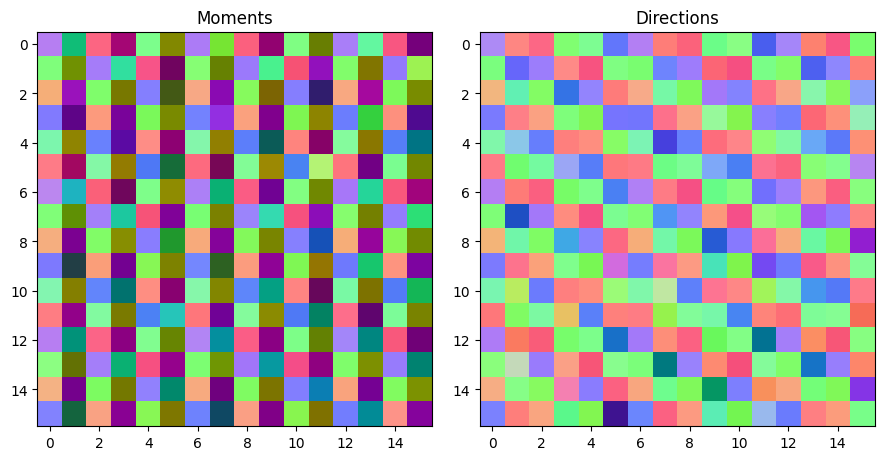

In [65]:
fig = create_fig_moments(pred_rays[0].get_moments(), pred_rays[0].get_directions())

# save subplot
# remove margins
fig.tight_layout()
fig.savefig("moments_directions.png")


In [27]:
import torchvision

In [30]:
torchvision.utils.save_image(test_images[:16], "test_images.png")